In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
from scipy.sparse.linalg import qmr, bicgstab

## Motivation
This is useful if you want to compute any reflection spectrum of a device

In [2]:
L0 = 1e-6;  #length unit: microns
wvlen = 0.35;  # wavelength in L0

Npml = 1*np.array([0,0,15]);  # [Nx_pml Ny_pml]
xrange = 0.5*np.array([-1, 1]);  # x boundaries in L0
yrange = 0.5*np.array([-1, 1]);  # y boundaries in L0
zrange = 0.5*np.array([-1, 1]);
N = np.array([91, 91, 91])
Nz = N[-1]
Nx = N[0]
Ny = N[1]
x = np.linspace(xrange[0], xrange[1], N[0])
y = np.linspace(yrange[0], yrange[1], N[1])
z = np.linspace(zrange[0], zrange[1], N[2])

[XX,YY,ZZ] = np.meshgrid(x,y,z)
print(N)

[91 91 91]


## notes
Since we're in cartesian

In [18]:
eps_r = np.ones(N);
Jz = np.zeros(N).astype('complex'); 
Jy = np.zeros(N).astype('complex'); 
Jx = np.zeros(N).astype('complex'); 


## unidirectional source, normal incidence
THETA = 0
PHI = 0
degrees = np.pi/180
kx = (2*np.pi/wvlen)*np.sin(THETA*degrees)*np.sin(PHI*degrees);
ky = (2*np.pi/wvlen)*np.cos(THETA*degrees)*np.sin(PHI*degrees);
kz = (2*np.pi/wvlen)*np.cos(PHI*degrees)
x_vec = np.linspace(xrange[0],xrange[1], Nx)
y_vec = np.linspace(yrange[0], yrange[1], Ny)
## the source must be defined on a plane
print(kx, ky, kz)
xx, yy= np.meshgrid(x_vec, y_vec, indexing = 'ij')

# source[:, ind_src] = np.exp(-1j*(kx*x_vec)); #this sets kx = 0; or theta = 0;
# source[:, ind_src-1] = source[:, ind_src]*np.exp(-1j*(ky * dL) - 1j*np.pi);
dz = np.diff(zrange)/Nz
Jx[:,:,40] = np.exp(-1j*(kx*xx+ky*yy))
Jy[:,:,40] = np.exp(-1j*(kx*xx+ky*yy))

Jx[:,:,39] = Jx[:,:,40]*np.exp(-1j*(kz * dz) - 1j*np.pi); ## it's a scalar phase...but I would imagine it's different for x vs y
Jy[:,:,39]= Jx[:,:,40]*np.exp(-1j*(kz * dz) - 1j*np.pi);

eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


0.0 0.0 17.951958020513104


In [19]:
print(wvlen, xrange,zrange, L0,N, eps_r.shape)

0.35 [-0.5  0.5] [-0.5  0.5] 1e-06 [91 91 91] (91, 91, 91)


In [20]:
A,b, Ch = fd3d.curlcurlE(L0, 
                         wvlen, 
                         xrange, 
                         yrange, 
                         zrange, 
                         eps_r_tensor_dict, 
                         JCurrentVector,Npml, 
                         s = -1
                        )

(2260713,)


In [21]:
#symmetrizer
# Sxf, Syf, Szf, Sxb, Syb, Szb =  create_sc_pml(omega, dL, N, Npml, eps0, eta0)
# Pl, Pr = create_symmetrizer(Sxf, Syf, Szf, Sxb, Syb, Szb)



In [22]:
%%time
#x, info = qmr(A, b, maxiter = 2000)
x, info = bicgstab(A,b, maxiter = 2000);
print(info)

0
CPU times: user 13min 33s, sys: 25.8 s, total: 13min 59s
Wall time: 1min 48s


In [23]:
y = Ch@x
print(y.shape, A.shape)

(2260713,) (2260713, 2260713)


In [24]:
# flipped Ez looks like Ey, Ey looks like Ex, Ex looks like Ez
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

Hx =  y[0:M].reshape(N, order = 'F')
Hy =  y[M:2*M].reshape(N, order = 'F')
Hz =  y[2*M:].reshape(N, order = 'F')



0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_80901/1868044685.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90


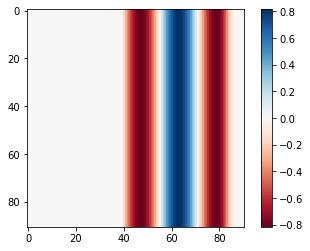

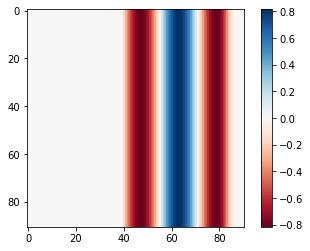

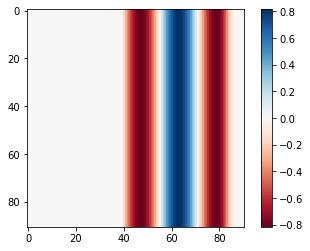

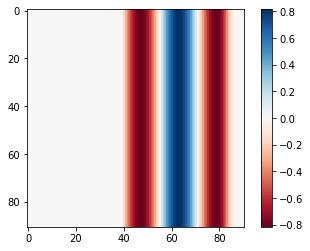

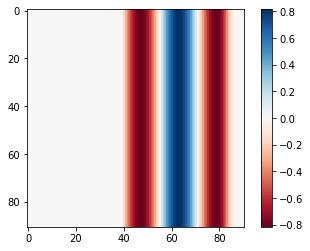

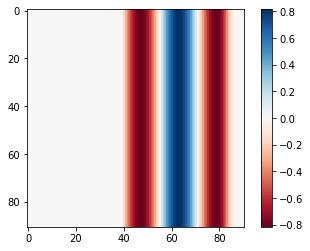

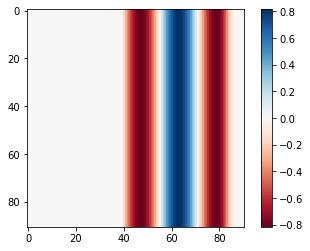

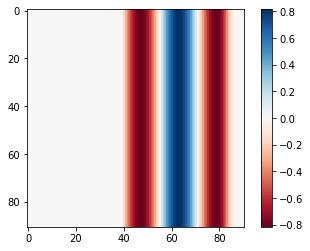

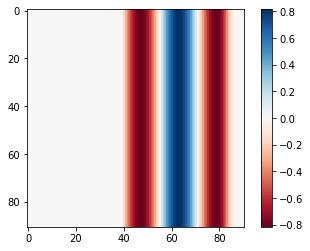

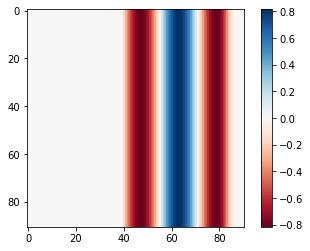

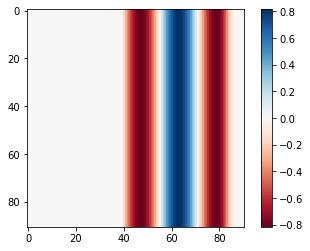

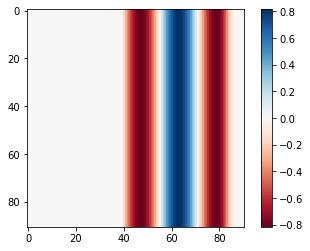

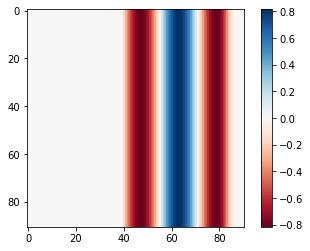

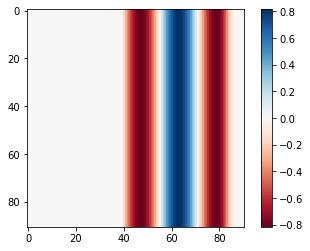

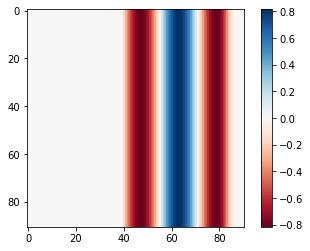

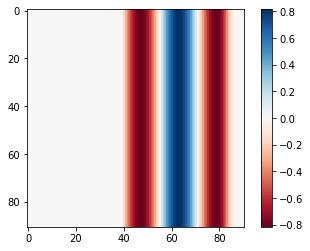

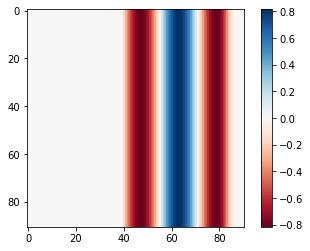

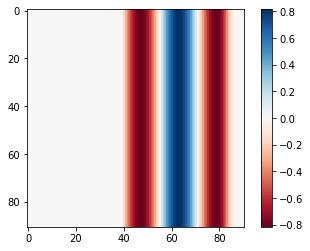

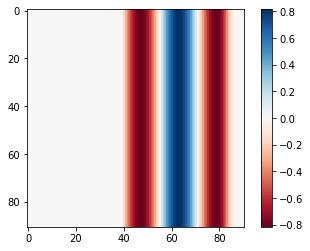

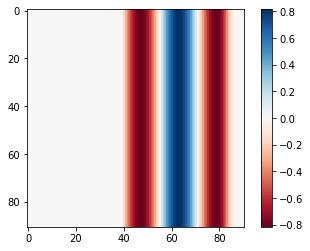

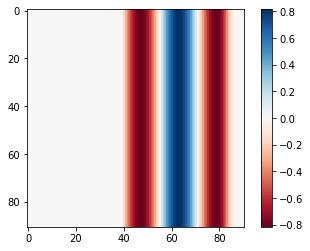

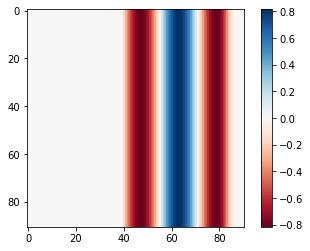

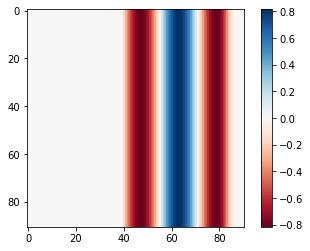

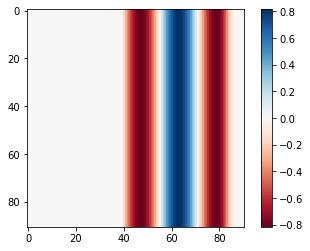

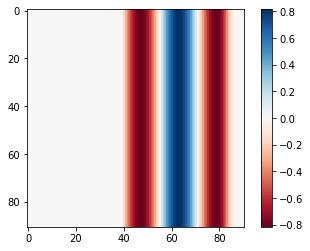

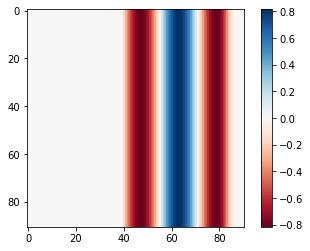

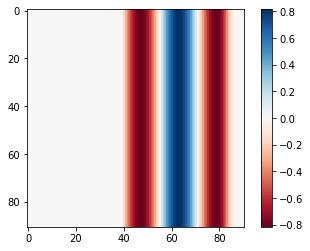

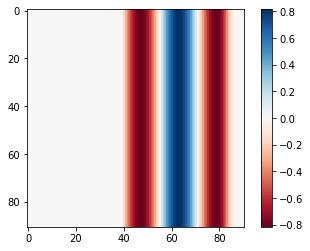

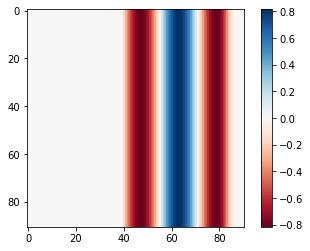

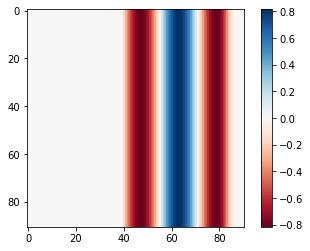

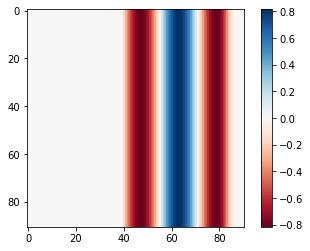

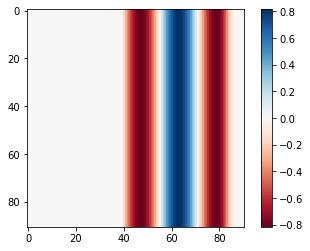

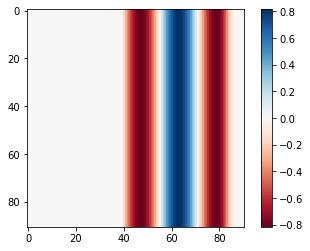

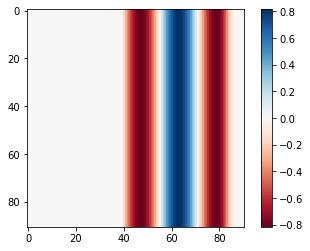

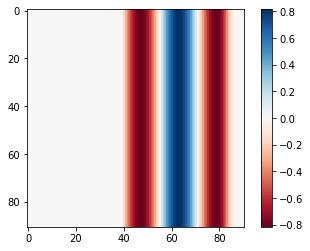

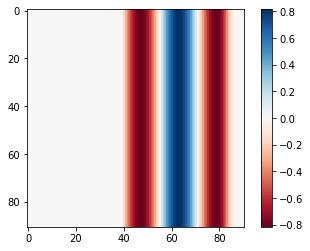

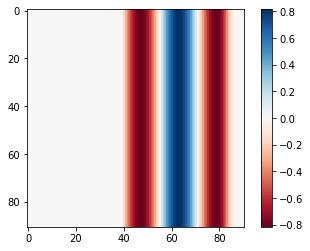

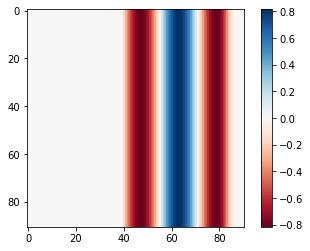

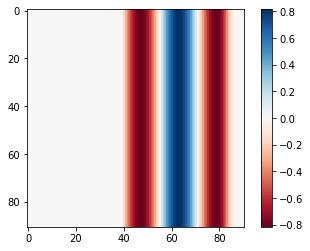

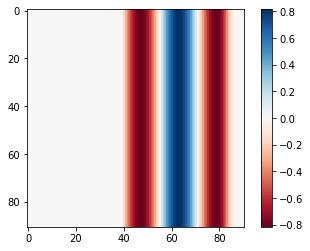

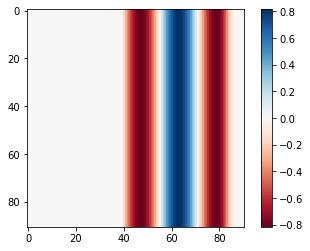

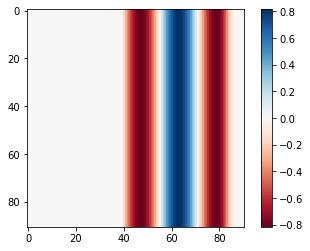

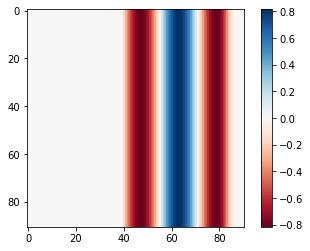

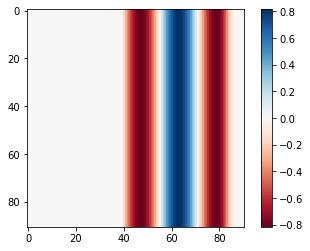

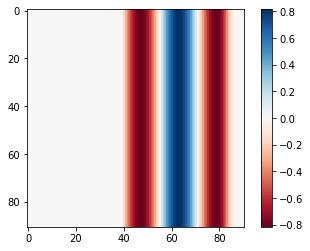

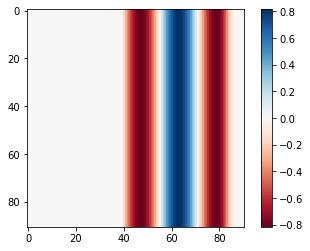

In [25]:
%matplotlib inline
for i in range(0,N[0],2):
    print(i)
    plt.figure()
    plt.imshow(np.real(Ey[:,i,:]), cmap = 'RdBu');
    #plt.clim(0,0.5e-2)
    plt.colorbar()
    

/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_80901/2908216757.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


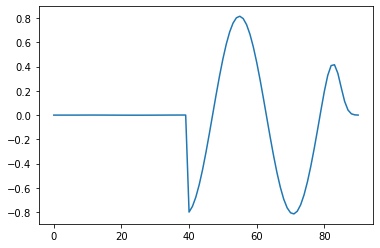

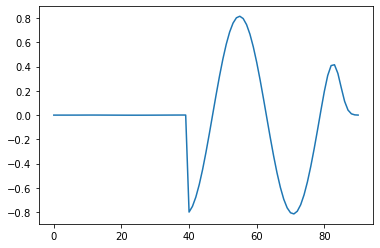

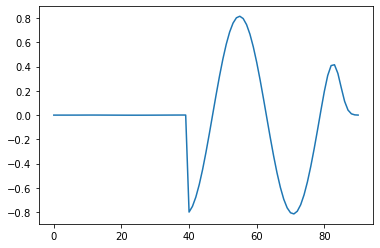

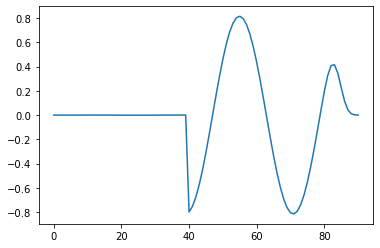

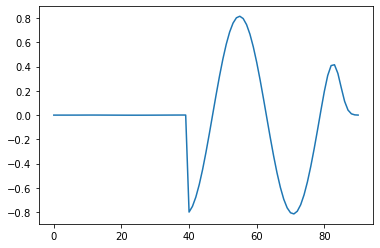

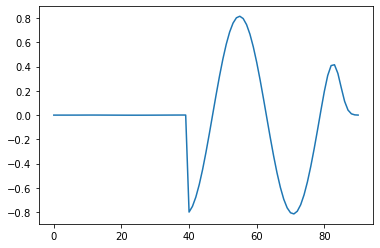

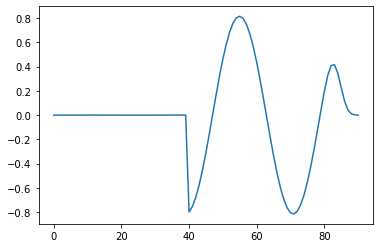

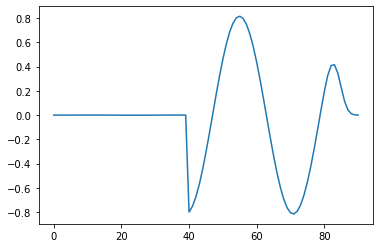

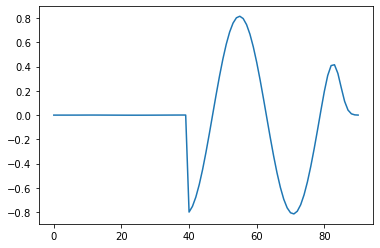

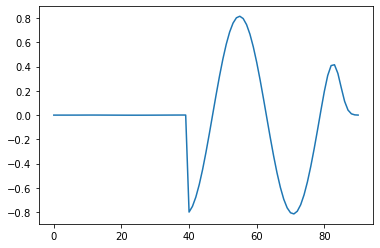

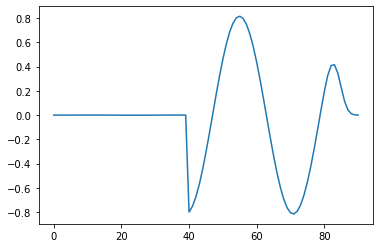

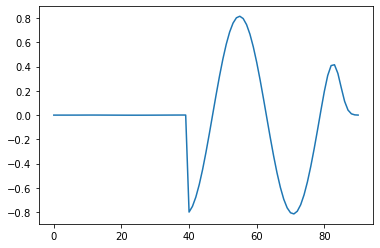

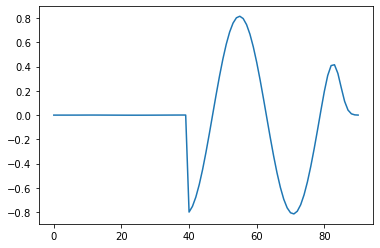

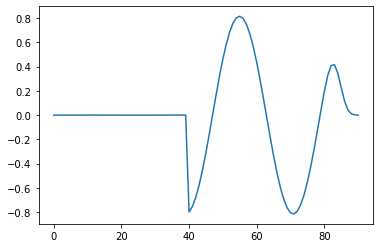

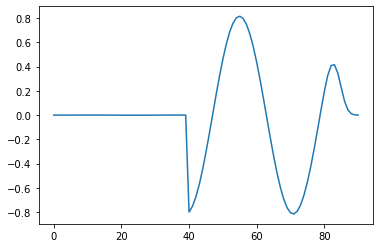

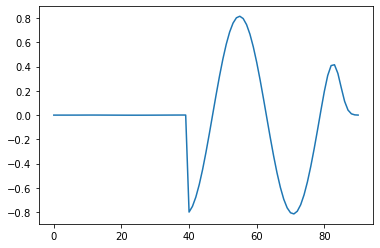

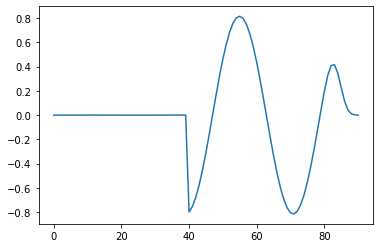

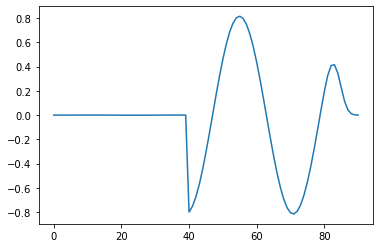

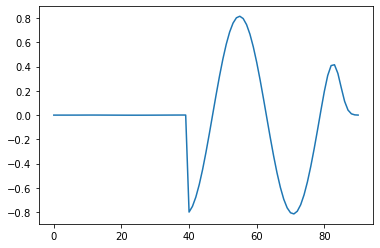

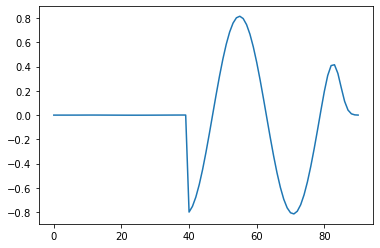

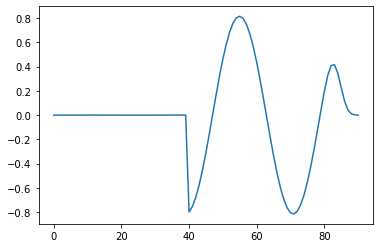

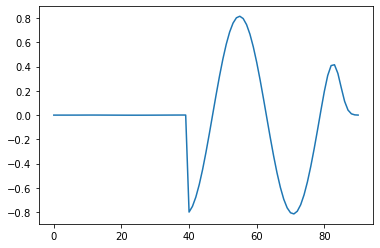

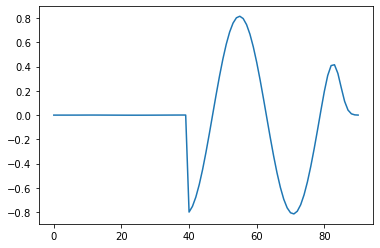

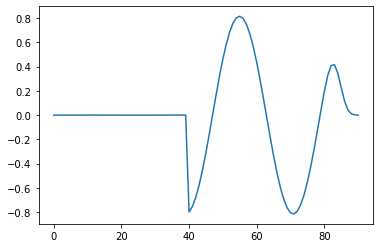

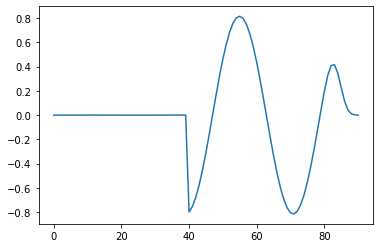

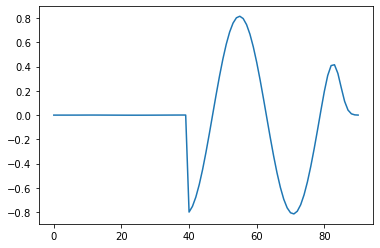

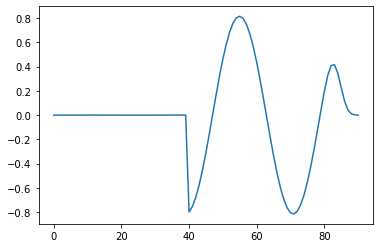

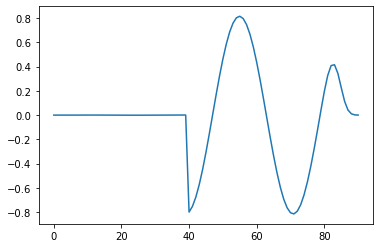

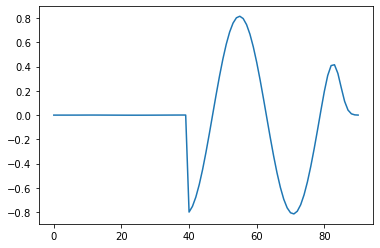

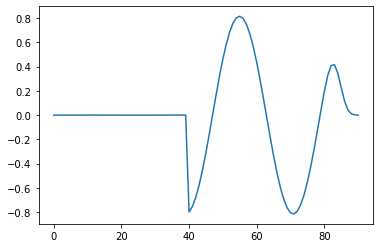

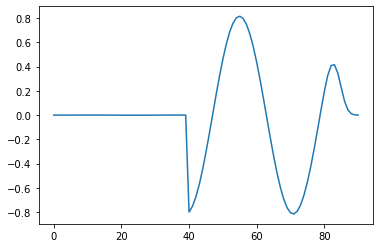

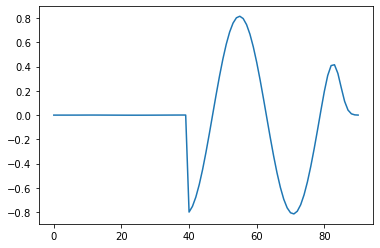

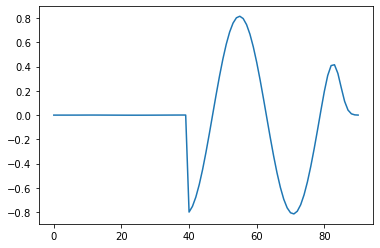

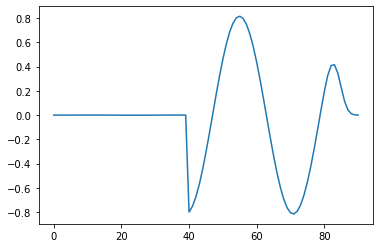

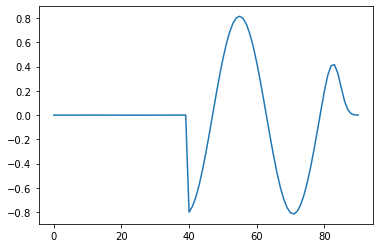

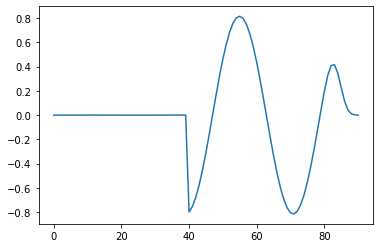

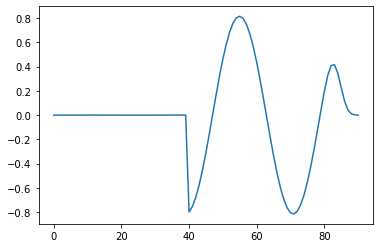

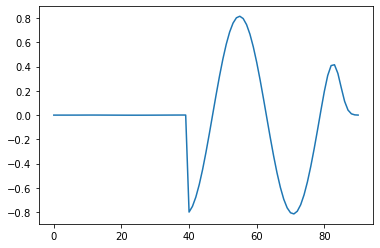

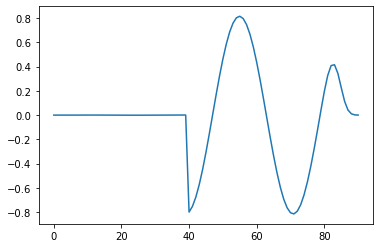

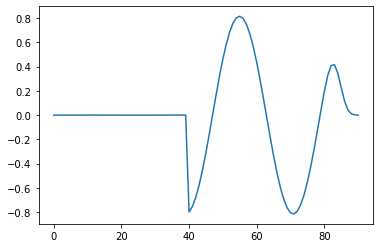

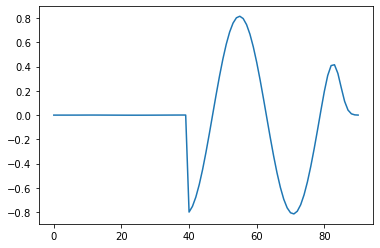

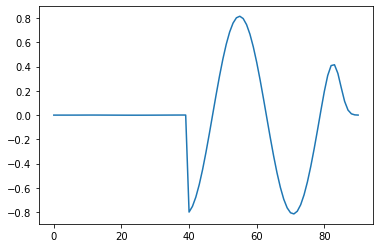

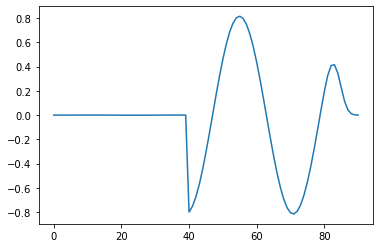

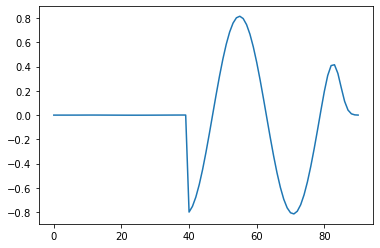

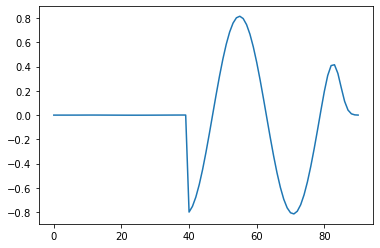

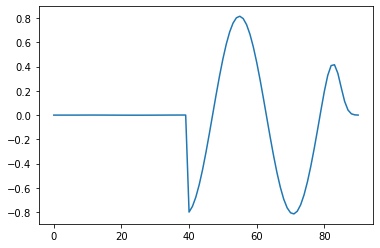

In [26]:
for i in range(0,N[0],2):
    plt.figure()
    plt.plot(np.imag(Ey[i,25,:]))
    #plt.ylim(-1e-2,1e-2)


In [27]:
print(x.shape)

(2260713,)


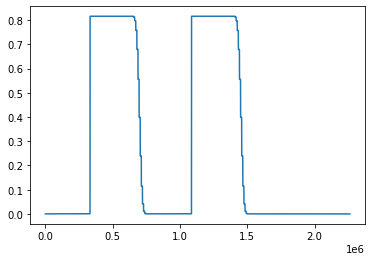

In [28]:
plt.plot(np.abs(x))
plt.show()